# Precision-landing of a Parrot drone 

This tutorial describes the precision control of a Parrot drone to perform a precision landing, the drone is roughly 30\*30cm and should land in a 60\*60cm area inside a box.

# System description

The drone is a Parrot drone, controlled either via speed or via position command (performed using its internal controller). 
The drone starts a few meters above and a few meters away from the box. 
Initial strategy was to perform image recognition to locate the box, actual solution was to use a QR-code to perform quick and precise recognition of the box's center:

![drone real](images/drone_real-min.jpg)

The difficulty lies in the fact that the computation is made on an external PC being subject to communication delays when sending commands or receiving data from the drone. 
These data are composed of the drone's odometry and video flux from its camera.


![simple diagram](images/simple_diagramm.jpg)


# 1. QR code detection

## QR code selection

### Size


## QR code recognition

## Relative positioning

### Managing uncertainty

### Video flux

# 2. Drone control in ideal case

Let's start to design of our controller in an ideal case, i.e. the controller is having perfect information from the environment, perfect camera reading and perfect communication.

## The basics : PID control

We will control our drone based on the relative position with the target, which is :
$$
(x_{drone}-x_{target},y_{drone}-y_{target},z_{drone}-z_{target},\theta_{drone}-\theta_{target})
$$

all expressed in meter.

All dimensions : x, y, z and theta can be treated with a dedicated PID of the form :

$$
u(t) = K_p \, e(t) + K_i \int_0^t e(\tau) \, d\tau + K_d \frac{de}{dt},

where:
- u(t) is the command in cm in a direction,
- $K_p$ is the proportional gain,
- $K_i$ is the integral gain,
- $K_d$ is the derivative gain,
- e(t) is the error between the target and the drone.
$$

For sake of simplicity and visual behavior, z-axis will be treated with a constant descent speed which helps to avoid small oscillations. 

## Drone model

Parrot Drone has position or stick control modes. Position control ensures the drone reaches the correct position, but creates a-coup, where stick is giving a constant speed to the motors, resulting in a drone speed that depends on the environment.

Mathematically, a stick-control drone can be seen as "pure-integrator", it integrates the commands to give drone's position :

$$
x(t) = \int_0^t u(\tau) d\tau 
$$

`The reality is a bit more complex but this will be enough to grasp the following examples.

Finally, Parrot Drones can't be landed using z-direction only, it has to be sent to LANDING-MODE, resulting in a direct descent to the ground, without $x/y/\theta$ control. This is activated in the simulation when the drone is below 40cm. The drone can move up to 10cm during this phase, this will be simulated in next section.

## First example

PID will take the shortest x/y path and generate straight lines in absence of yaw errors, z speed is set to constant -0.2m/s. The effect of the LANDING-MODE activated at 40cm above the ground shows the difficulty to reach the center at the right time.



In [ ]:
from DroneEnv import DroneLandingEnv
from PIDCon import PIDController
from PID_run import run_pid_simulation

sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 0.1  # controller step (1 Hz)

pid = PIDController(Kp=[1.0,1.0,1.0, 0.0], 
                    Ki=[0.0,0.0,0.0,0.0], 
                    Kd=[0.0,0.0,0.0,0.0], 
                    dt=controller_dt, 
                    integral_limit=0.5, 
                    z_fixed_speed= -0.2)

states, target = run_pid_simulation(
        env = env,
        pid = pid,
        init_mode='fixed',
        plot=True)


A small integral contributions helps reaching the center with more precision:

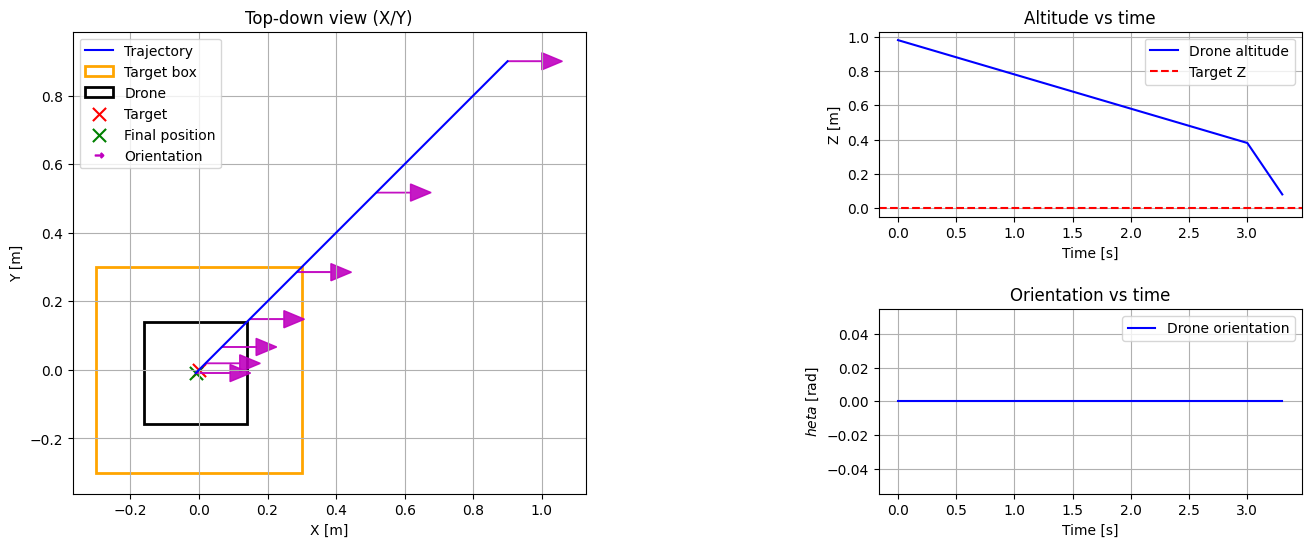

In [2]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 0.1  # controller step (1 Hz)

pid = PIDController(Kp=[1.0,1.0,1.0, 0.0], Ki=[0.1,0.1,0.0,0.0], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True)


## How to handle yaw

Previous example was assuming correct yaw. When using a PID for yaw as well, we obtain more complex, less straightforward trajectory, as the drone is rotating while moving.

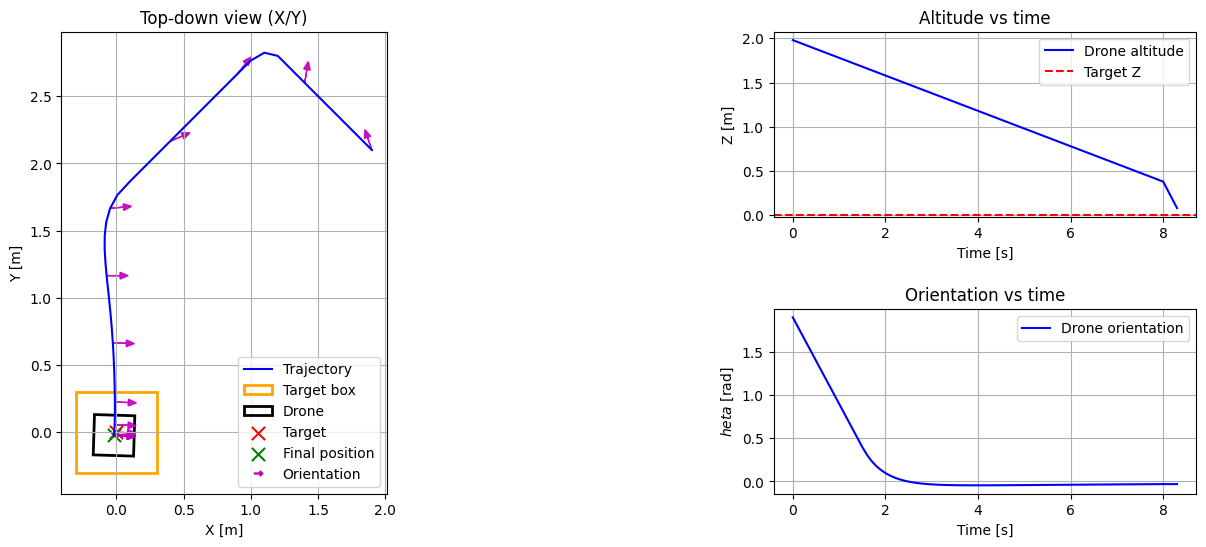

In [3]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 0.1  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])

## Tuning with delay

Even in the ideal case, there is something we forgot, we did not take into account that the there is a computation+communication delay between the drone and the computer. This means that the controller is at fixed lower frequency than the drone (10 Hz simulation here). Following 

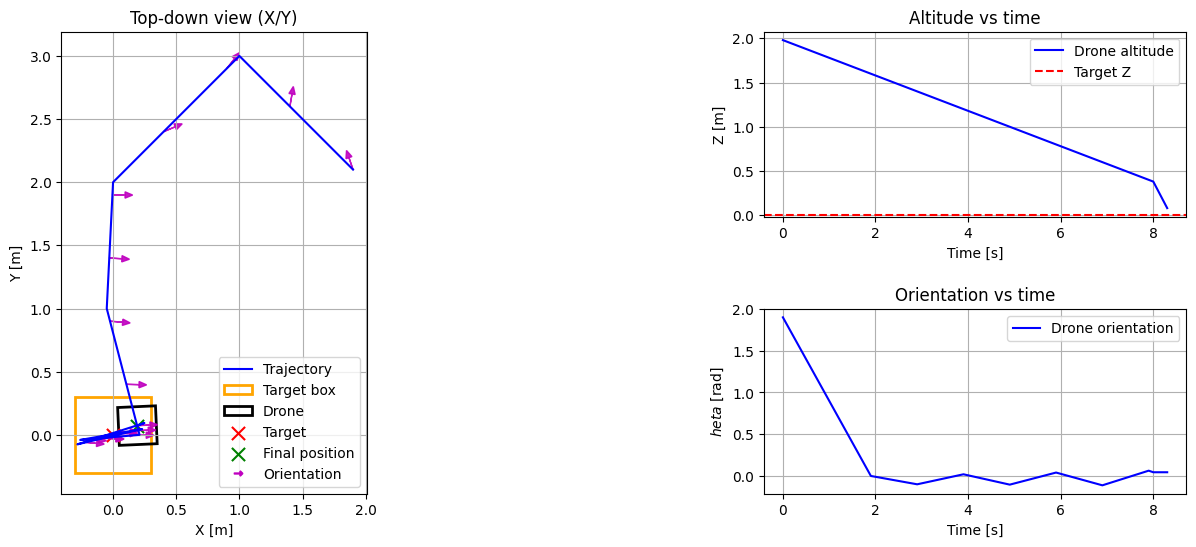

In [4]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])

Delay introduction shows 2 things:
- It makes the drone turning around itself which causes a deviation from the target
- It makes the drone oscillates around the target in every direction

The drone is bounded-stable, no more asymptotically stable.
To solve the first issue, we will treat the yaw axis in 2-steps:
- No yaw movement if the drone is more than 0.3m away of the target
- Yaw + x/y axis if the drone is 0.3m close to the target

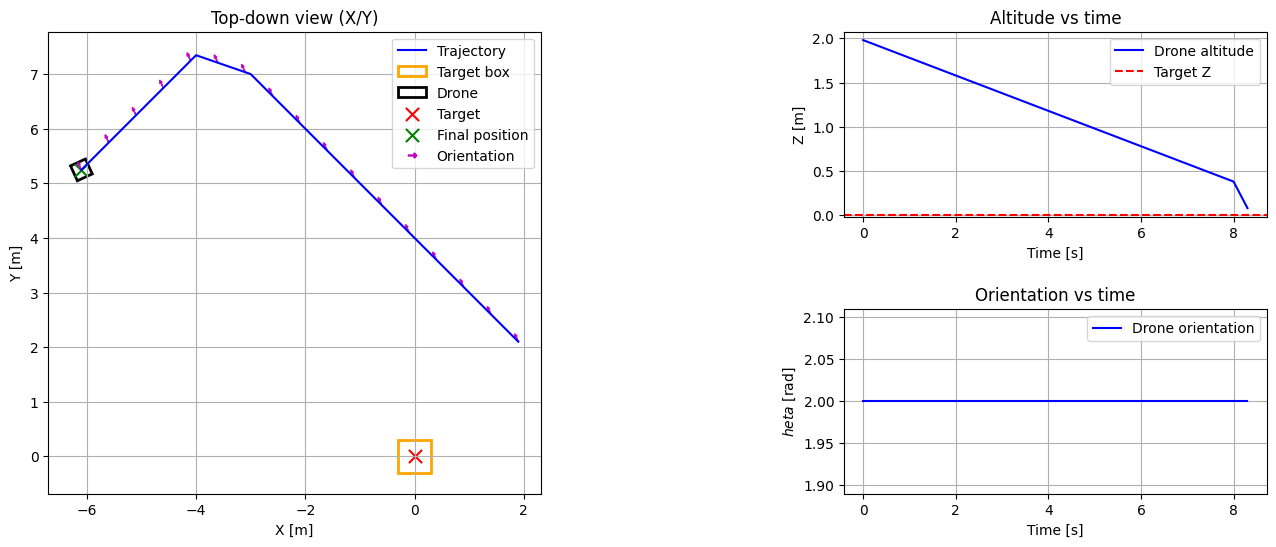

In [5]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])

**Where does the non-straight line at the beginning comes from?**

Well this a bit tricky, even if the drone starts at x=2m and y =2m, in its own referential, x error is well higher than y error. 


Second issue can be treated with smoother control (lower coefficients) when being closer to the target: coefficients are divided by 2 when being above the target.


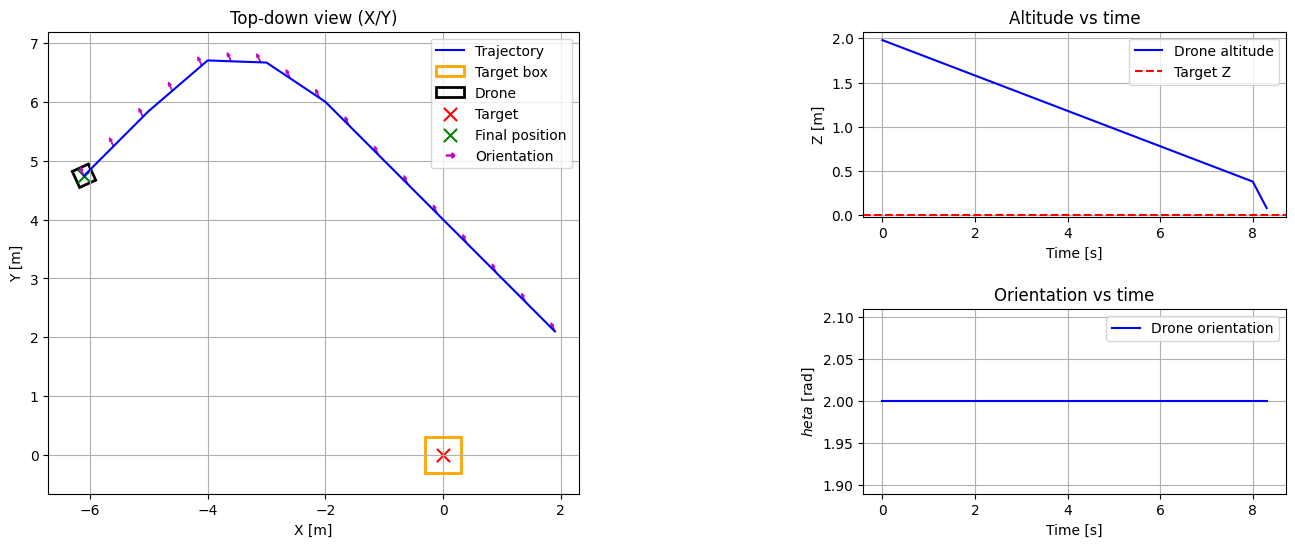

In [6]:
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)

states, target = run_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0])

# 3. Drone control in real situation - Study of the impact of delay and losses

## Well that's done, what could go wrong in real life?

![complex diagram](images/complex_diagram.jpg)

## Noise

## Wind effect


## Packet loss

## Non-fixed delays



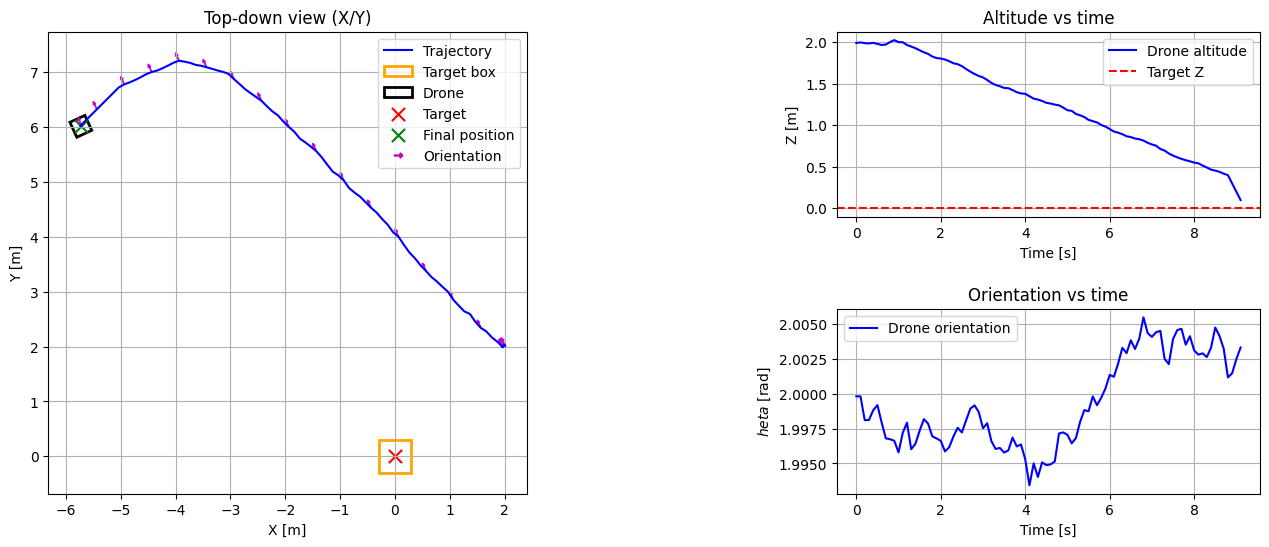

In [7]:
from PID_run import run_noisy_pid_simulation
sim_dt = 0.1         # simulation step (10 Hz)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
controller_dt = 1.0  # controller step (1 Hz)

pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)

# Delay and packet loss parameters
max_delay_steps = 3  # 1 or 2 sim steps additional delay
p_loss = 0.15      # packet loss probability
wind_std=[0.1, 0.1, 0.1, 0.01]
noise_std = 0.02

states, target = run_noisy_pid_simulation(env = env, pid = pid, init_mode='fixed', plot=True, init_pos = [2.0,2.0,2.0,2.0], max_delay_steps = max_delay_steps, p_loss = p_loss, wind_std = wind_std, noise_std = noise_std)


In [8]:
sim_dt = 0.1         # simulation step (10 Hz)

# Delay and packet loss parameters
max_delay_steps = 3  # 1 or 2 sim steps additional delay
p_loss = 0.15      # packet loss probability
wind_std=[0.1, 0.1, 0.1, 0.01]
noise_std = 0.02

stables = []

for i in range(0,15):
    env = DroneLandingEnv(render_mode=None, dt=sim_dt)

    pid = PIDController(Kp=[2.0,2.0,2.0, 2.0], Ki=[0.1,0.1,0.0,0.2], Kd=[0.0,0.0,0.0,0.0], dt=controller_dt, integral_limit=0.5, z_fixed_speed= -0.2, yaw_2_steps =True, finer_gains=True)
    states, target = run_noisy_pid_simulation(env = env, pid = pid, init_mode='random', plot=False, max_delay_steps = max_delay_steps, p_loss = p_loss, wind_std = wind_std, noise_std = noise_std)
    
    tol =0.3
    x, y, z, theta = states[:,0], states[:,1], states[:,2], states[:,3]
    # Final horizontal error
    dx = abs(x[-1] - target[0])
    dy = abs(y[-1] - target[1])
    stable = (dx < tol) and (dy < tol)
    stables.append(stable)



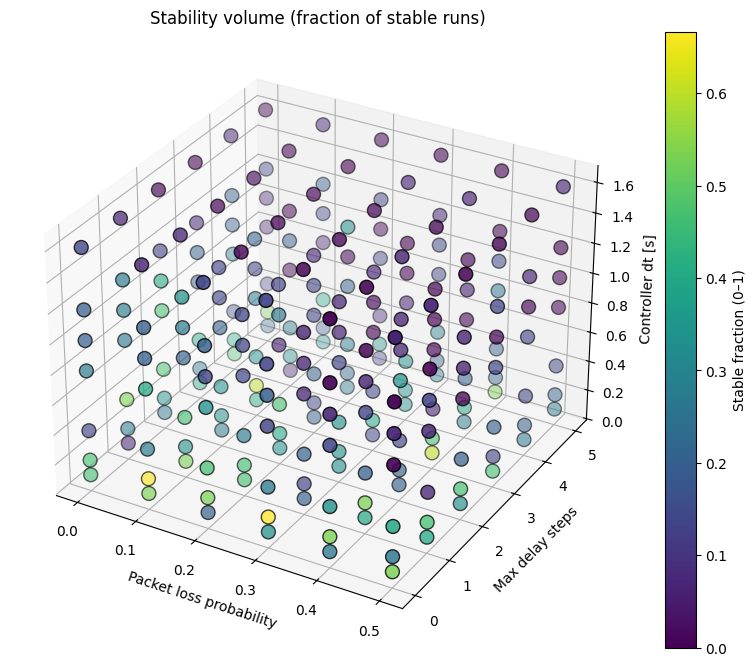

In [9]:
from PidEval import *

wind_std = [0.1, 0.1, 0.1, 0.01]
noise_std = 0.02

results = sweep_parameters(wind_std, noise_std)
plot_stability_volume(results)



--- Running sweep for Low wind ---


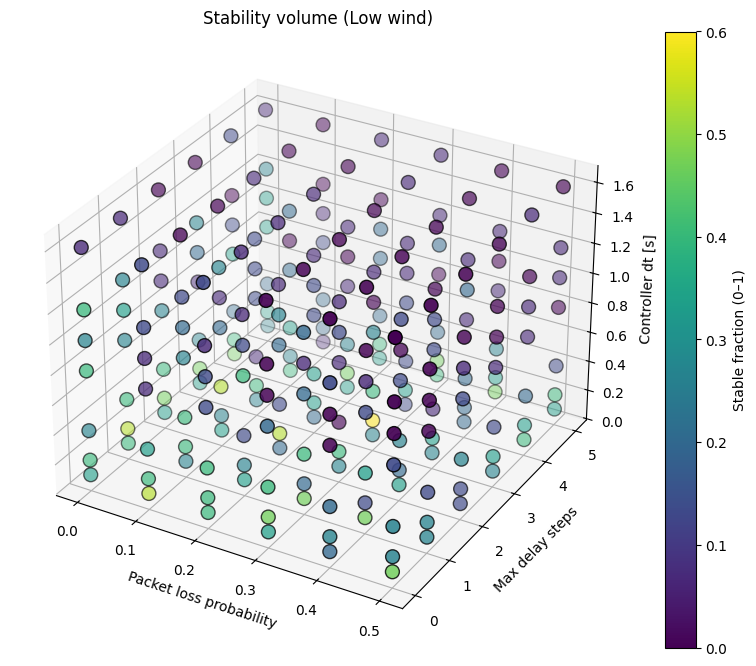


--- Running sweep for Mid wind ---


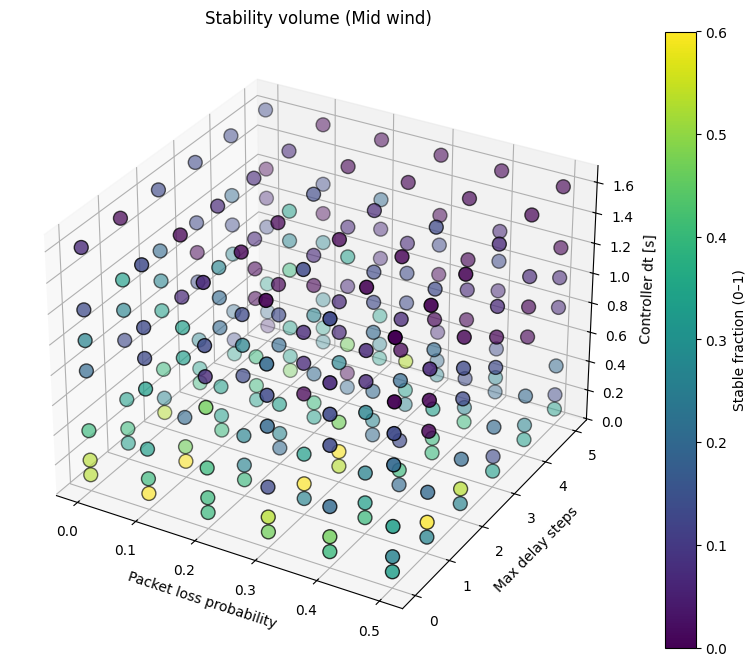


--- Running sweep for High wind ---


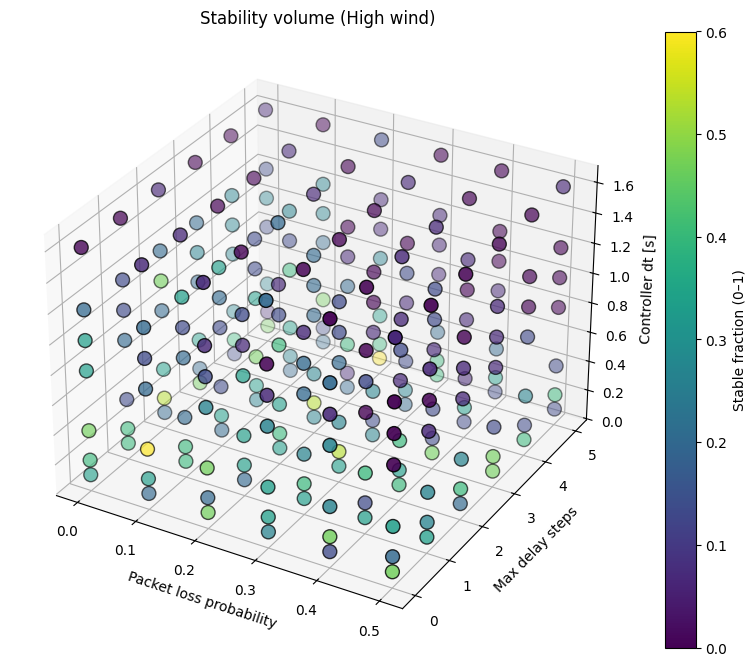

In [10]:
from PidEval import sweep_parameters, plot_stability_volume, plot_stability_volume_3D

noise_std = 0.05

# Three wind scenarios
wind_scenarios = {
    "Low wind":  [0.0, 0.0, 0.0, 0.0],
    "Mid wind":  [0.05, 0.05, 0.05, 0.01],
    "High wind": [0.1, 0.1, 0.1, 0.02],
}

for label, wind_std in wind_scenarios.items():
    print(f"\n--- Running sweep for {label} ---")
    results = sweep_parameters(wind_std, noise_std)
    plot_stability_volume(results, title=f"Stability volume ({label})")
    # plot_stability_volume_3D(results, title=f"Stability volume ({label})")



In [11]:
from DroneEnv import DroneLandingEnv, plot_xy_z,plot_trajectory_3d
from PIDCon import PIDController
import numpy as np

# --- Simulation with PID ---
sim_dt = 0.1         # simulation step (10 Hz)
controller_dt = 0.8  # controller step (1 Hz)
steps_per_ctrl = int(controller_dt / sim_dt)
env = DroneLandingEnv(render_mode=None, dt=sim_dt)
obs, info = env.reset(random_init=False)
done = False
states = []

# Example PID gains (tune these!)
pid = PIDController(Kp=[1.5,1.5,0.0, 1.0], 
                    Ki=[0.5,0.5,0.0,0.0], 
                    Kd=[0.0,0.0,0.0,0.0], 
                    dt=controller_dt, 
                    integral_limit=0.5, 
                    z_fixed_speed= -0.2)

# Initialize control
last_action = np.zeros(4)  # last applied action
pending_actions = []        # queue of (time_to_apply, action)

# Delay and packet loss parameters
max_delay_steps = 2  # 1 or 2 sim steps additional delay
p_loss = 0.1      # packet loss probability
wind_std=[0.1, 0.1, 0.02, 0.05]
noise_std = 0.01

step_count = 0

while not done:
    pos = obs[:4]
    vel = obs[4:]
    error = env.target - pos

    current_time = step_count * sim_dt

    # --- Controller update ---
    if step_count % steps_per_ctrl == 0:
        # PID computes control in WORLD frame
        world_cmd = pid.compute(error * (1 + np.random.randn(4) * noise_std))
        
        # --- Transform WORLD → DRONE frame ---
        theta = pos[3]
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([
            [c, s, 0],
            [-s, c, 0],
            [0, 0, 1]
        ])  # world-to-body rotation (transpose of body-to-world)
        
        body_cmd = np.zeros_like(world_cmd)
        body_cmd[:3] = R @ world_cmd[:3]   # rotate linear part
        body_cmd[3] = world_cmd[3]         # yaw rate unchanged
        
        # Packet loss check
        if np.random.rand() > p_loss:
            additional_delay = (
                np.random.randint(1, max_delay_steps + 1)
                if max_delay_steps > 0
                else 0
            )
            apply_time = current_time + additional_delay * sim_dt
            pending_actions.append((apply_time, body_cmd.copy()))


    # --- Apply action according to delay queue ---
    # Find any actions whose apply_time <= current_time
    if pending_actions and pending_actions[0][0] <= current_time:
        _, last_action = pending_actions.pop(0)

    # Step simulation with wind
    obs, reward, terminated, truncated, info = env.step(last_action, wind_std=wind_std)
    states.append(obs.copy())
    step_count += 1
    done = terminated or truncated

env.close()

states = np.array(states)
x, y, z, theta = states[:,0], states[:,1], states[:,2], states[:,3]
target = env.target


# --- Plot results ---
plot_trajectory_3d(x, y, z, theta, target)
plot_xy_z(x, y, z, theta, target, env.dt)


TypeError: DroneLandingEnv.reset() got an unexpected keyword argument 'random_init'